# Elo Merchant Category Recommendation - Effect of target outliers on RMSE <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("input/train.csv")
df = reduce_mem_usage(df)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)


# How much could we improve?
We want to check how the proportion of correctly predicted target outliers (aprox -33.21) affects the RMSE. In order to decide if it is worth it to train some kind of churn model. The rest of the target values are merely predicted as the mean value of all the normal targets.

In [4]:
n = df.shape[0]
prop = np.linspace(0.5, 1, 6)
RMSE = [0]*len(prop)

# Compute the mean of the normal scores
target_mean = df[df['target']>-33]['target'].mean()   
print("Mean without outliers: {:}".format(target_mean))

Mean without outliers: -0.0


In [ ]:
df_out = df[df['target']<-33]['target']
out = df_out.values[0]
n_out = df_out.shape[0]
targets = np.concatenate((df_out.values, df[df['target']>-33]['target'].values))

for i in range(len(prop)):
    n_ok = int(round(prop[i]*n_out))
    pred = [out]*n_ok + [0]*(n-n_ok)
    RMSE[i] = mean_squared_error(targets, pred) #math.sqrt(((pred-targets)**2).mean())

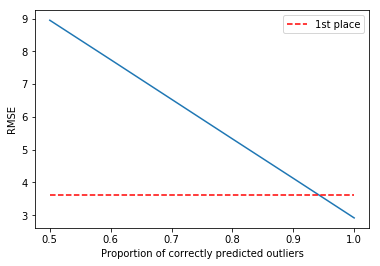

In [ ]:
plt.plot(prop, RMSE)
plt.xlabel("Proportion of correctly predicted outliers")
plt.plot(prop, [3.61]*len(prop), 'r--', label="1st place")
plt.ylabel("RMSE")
plt.legend(loc='upper right')

# Churn model

In [6]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [7]:
df_trans = pd.concat([df_hist_trans, df_new_trans])
df_trans = df_trans[df_trans['card_id'].isin(df['card_id'].unique())].reset_index()
df_trans.head()

,index,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,400,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
1,401,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
2,402,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33
3,403,Y,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19
4,404,Y,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33


## Feature extraction
First, all the features regarding amount of transactions should be rescaled to get meaninful values. Some features that may be useful for churn prediction: 
- Total amount of transactions
- Median value of purchase amount
- Number of different merchants
- Some measures of stability over time. Although we can not do it properly grouping by merchants, since the transaction data are limited to (at most) three consecutive months for the same merchant.
    - Time since the last transaction.
    - Mean purchase amount in the last month (or 2 or 3) compared with the mean amount.
    - Some measure of how many merchants users have stopped visiting (although it may be difficult taking into account that the transactions are limited to 3 months per merchant)
    - Time between transactions for prefered merchant (to check if it increases over time)
- Maybe if they have transactions for new merchants (new transactions file), it means that they keep using the card.

In [194]:
df['churn'] = 1*(df['target']<-33)
df_trans['purchase_amount_raw'] = df_trans['purchase_amount']/0.00150265118 + 497.06
df_trans = df_trans[df_trans['authorized_flag']=='Y'] #We will only use authorized transactions

In [9]:
df_amount_trans = df_trans.groupby('card_id')['purchase_amount_raw'].sum().reset_index().rename(columns={'purchase_amount_raw': 'sum_purchase_amount'})
df_n_trans = df_trans.groupby('card_id')['purchase_amount_raw'].count().reset_index().rename(columns={'purchase_amount_raw': 'n_purchase_amount'})
df_n_merch = df_trans.groupby('card_id')['merchant_id'].nunique().reset_index().rename(columns={'merchant_id': 'n_merchant'})

In [10]:
#only use cards with transactions
df_log = df.join(df_amount_trans.set_index('card_id'), on='card_id', how='inner') 
df_log = df_log.join(df_n_trans.join(df_n_merch.set_index('card_id'), on='card_id').set_index('card_id'), on='card_id')

In [11]:
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101


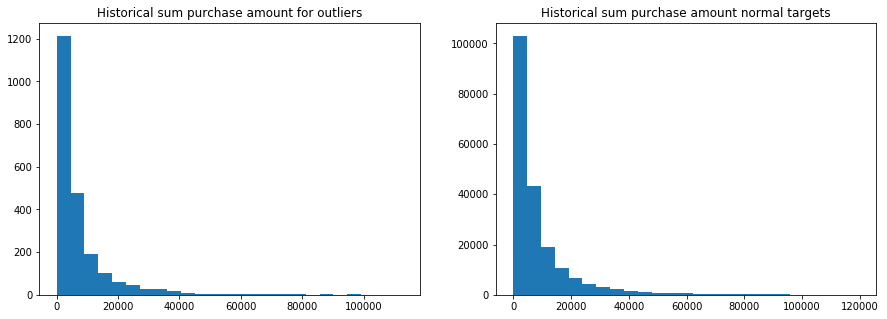

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.sum_purchase_amount < 120000)]['sum_purchase_amount'], bins=25)
plt.title('Historical sum purchase amount for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.sum_purchase_amount < 120000)]['sum_purchase_amount'], bins=25)
plt.title('Historical sum purchase amount normal targets')
plt.show()

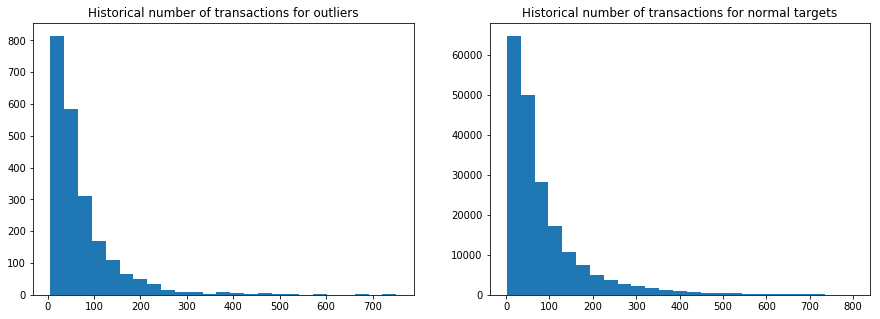

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.n_purchase_amount < 800)]['n_purchase_amount'], bins=25)
#plt.hist(df_log[df.target<-33]['n_purchase_amount'], bins=25)
plt.title('Historical number of transactions for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.n_purchase_amount < 800)]['n_purchase_amount'], bins=25)
#plt.hist(df_log[df.target>-33]['n_purchase_amount'], bins=25)
plt.title('Historical number of transactions for normal targets')
plt.show()

It seems that the outliers have slightly less number of transactions that the normal users.

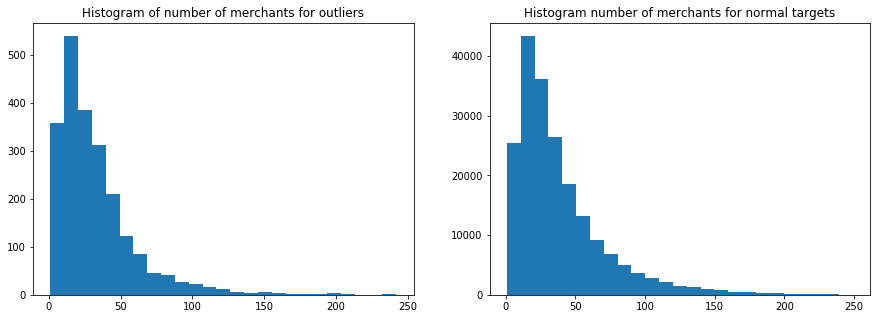

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.n_merchant < 250)]['n_merchant'], bins=25)
#plt.hist(df_log[df.target<-33]['n_merchant'], bins=25)
plt.title('Histogram of number of merchants for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.n_merchant < 250)]['n_merchant'], bins=25)
#plt.hist(df_log[df.target>-33]['n_merchant'], bins=25)
plt.title('Histogram number of merchants for normal targets')
plt.show()

The outliers also seem to have less number of different merchants.

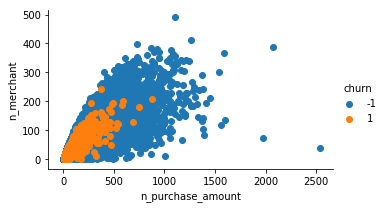

In [17]:
fg = sns.FacetGrid(data=df_log, hue='churn', aspect=1.61)
fg.map(plt.scatter, 'n_purchase_amount','n_merchant').add_legend()

Let's now compute the time since the last transaction, up to May 1th, 2018.

In [234]:
df_trans['purchase_date'] = pd.to_datetime(df_trans['purchase_date'])
df_agg_time = df_trans.groupby('card_id').agg({'purchase_date': ['max']}).reset_index(drop=False)
df_agg_time.columns = ['card_id','purchase_date_max']
df_agg_time['last_date_uptonow'] = (datetime.datetime.strptime('May 1 2018', '%b %d %Y') - df_agg_time['purchase_date_max']).dt.days
df_agg_time.head()

,card_id,purchase_date_max,last_date_uptonow
0,C_ID_00007093c1,2018-04-09 16:23:59,21
1,C_ID_0001506ef0,2018-03-22 09:14:30,39
2,C_ID_000183fdda,2018-04-30 14:59:53,0
3,C_ID_00027503e2,2018-01-19 12:07:27,101
4,C_ID_0002c7c2c1,2018-03-24 08:43:37,37


In [260]:
df_agg_time.drop('purchase_date_max', axis=1, inplace=True)
df_log = df_log.merge(df_agg_time, on='card_id', how='left')
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,last_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0,20646.298828,270,116,1
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,0,29577.232422,345,147,31
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,0,1890.995972,42,14,2
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,0,5719.293945,84,57,12
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0,22311.408203,164,101,2


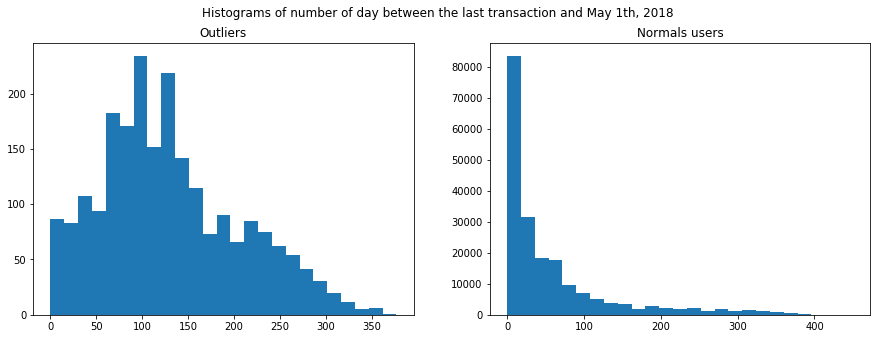

In [263]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_log[df_log['card_id'].isin(ids_all_outs)]['last_date_uptonow'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[df_log['card_id'].isin(ids_all_norms)]['last_date_uptonow'], bins=25)
plt.title('Normals users')
plt.suptitle('Histograms of number of day between the last transaction and May 1th, 2018')
plt.show()

Although the histograms don't have the exact same scale, we can see that there is a huge difference between both sets.

Let's see if we can see something different in the purchase curves if the users that are undistinguible with these two features.

In [12]:
def create_date_year_month(df, source_column, preposition):
    df[preposition + '_ym'] = df[source_column].dt.strftime('%Y') + '-' + df[source_column].dt.strftime('%m')    
    return df
df_trans = create_date_year_month(df_trans, 'purchase_date', 'purchase')

In [13]:
outs_ids = df_log[(df.target<-33) & (df_log.n_purchase_amount < 300) & (df_log.n_purchase_amount > 250) & (df_log.n_merchant < 100) & (df_log.n_merchant > 80)]['card_id'].values
normals_ids = df_log[(df.target>-33) & (df_log.n_purchase_amount < 300) & (df_log.n_purchase_amount > 250) & (df_log.n_merchant < 100) & (df_log.n_merchant > 80)].head(4)['card_id'].values

In [14]:
df_outs_plot = df_trans[df_trans['card_id'].isin(outs_ids)].groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_outs_plot.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_550f606893,2017-01,524.529785
1,C_ID_550f606893,2017-02,471.359894
2,C_ID_550f606893,2017-03,1817.319336
3,C_ID_550f606893,2017-04,1033.859863
4,C_ID_550f606893,2017-05,408.099884


In [15]:
df_normals_plot = df_trans[df_trans['card_id'].isin(normals_ids)].groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_normals_plot.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_37e3d6be84,2017-03,259.799774
1,C_ID_37e3d6be84,2017-04,119.199921
2,C_ID_37e3d6be84,2017-05,499.939453
3,C_ID_37e3d6be84,2017-06,701.869263
4,C_ID_37e3d6be84,2017-07,283.079468


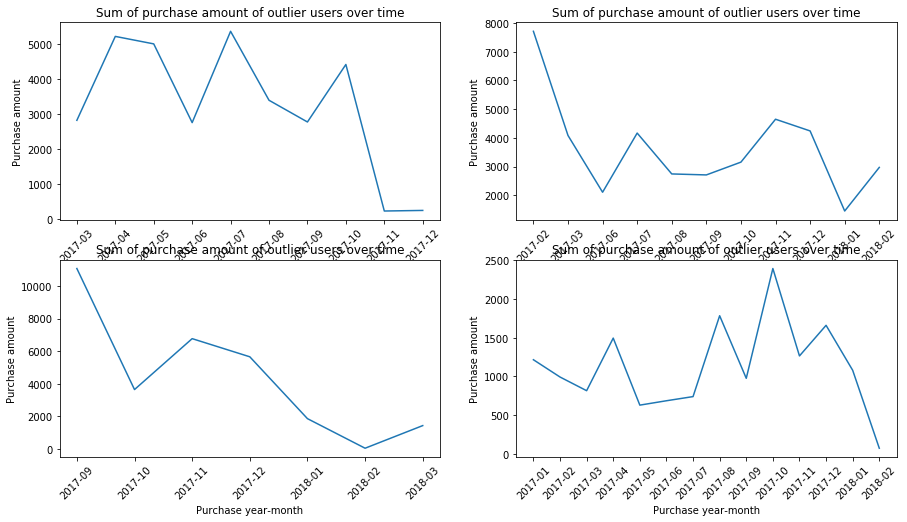

In [16]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_outs_plot[df_outs_plot.card_id==outs_ids[i]]['purchase_ym'], y=df_outs_plot[df_outs_plot.card_id==outs_ids[i]]['purchase_amount_raw'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Sum of purchase amount of outlier users over time')
    ax.set_xlabel('Purchase year-month')
    ax.set_ylabel('Purchase amount')
plt.show()

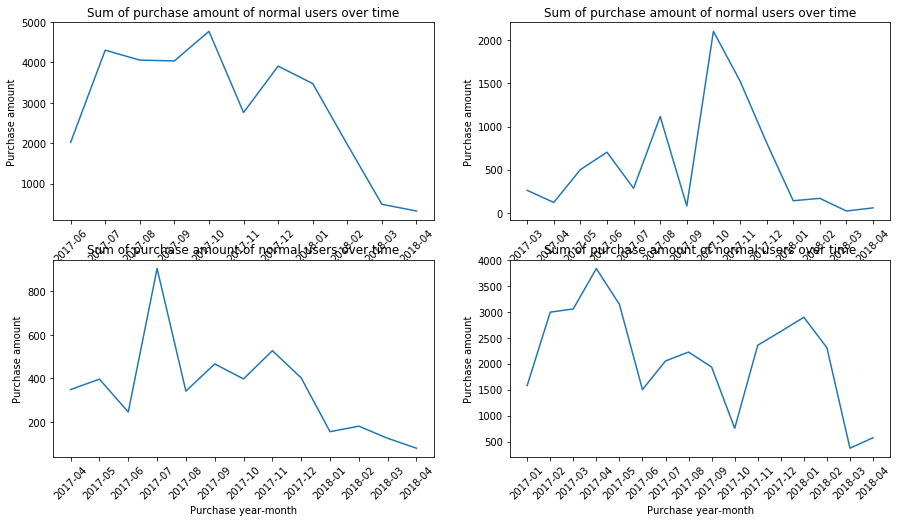

In [17]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_normals_plot[df_normals_plot.card_id==normals_ids[i]]['purchase_ym'], y=df_normals_plot[df_normals_plot.card_id==normals_ids[i]]['purchase_amount_raw'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Sum of purchase amount of normal users over time')
    ax.set_xlabel('Purchase year-month')
    ax.set_ylabel('Purchase amount')
plt.show()

It seems that the outlier users tend to expend more money at the begining, while the normal users tend to have the maximum values in the middle. Then we will adjust a second degree polynomial to the curves and check the coefficient of $x^2$.

In [18]:
def compute_shape(user):
    grid = np.linspace(-1,1,user['purchase_ym'].nunique())
    coeffs = np.polyfit(grid, user.groupby('purchase_ym')['purchase_amount_raw'].sum().values, 2)
    return(pd.DataFrame({'purchase_shape': [np.sign(coeffs[0])]}))

df_coeffs = df_trans.groupby('card_id')[['purchase_ym','purchase_amount_raw']].apply(compute_shape)
df_coeffs = df_coeffs.reset_index(level=0)

In [19]:
df_log = df_log.join(df_coeffs.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116,-1.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147,1.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14,1.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57,-1.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101,-1.0


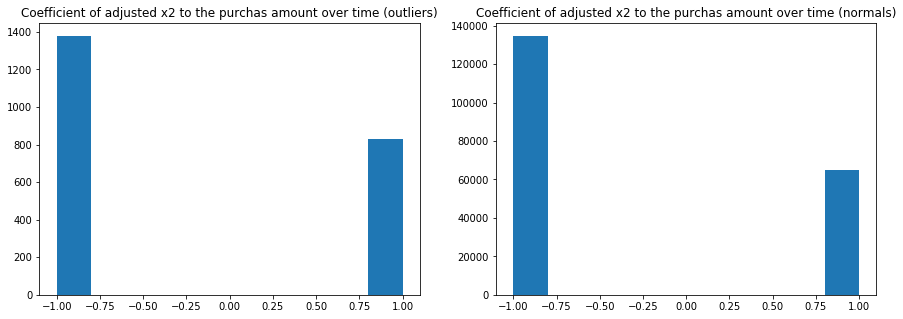

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[df_log['target']<-33]['purchase_shape'])
plt.title('Coefficient of adjusted x2 to the purchas amount over time (outliers)')
plt.subplot(1, 2, 2)
plt.hist(df_log[df_log['target']>-33]['purchase_shape'])
plt.title('Coefficient of adjusted x2 to the purchas amount over time (normals)')
plt.show()

We don't see a significative difference in the histograms of both sets, although it seems that the proportion of 1's for outliers in slightly bigger. <br>
Let's try to use the number of transactions instead of the amount.

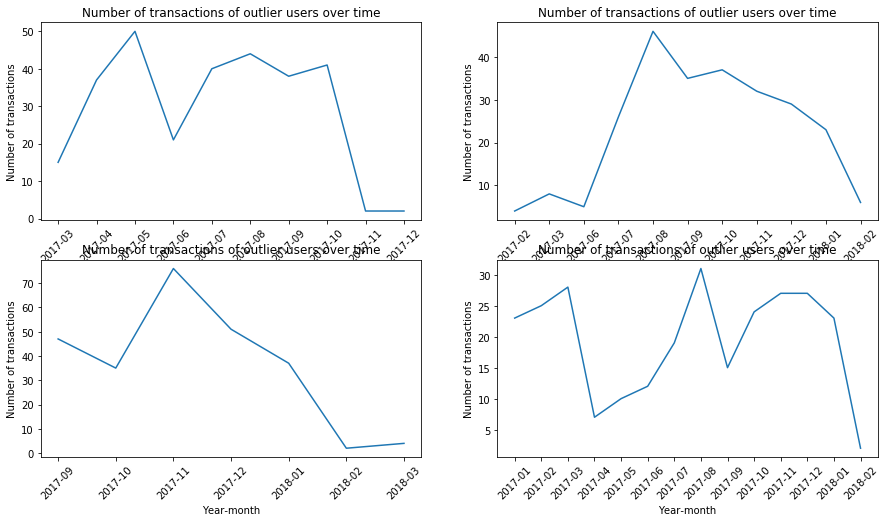

In [21]:
df_outs_temp = df_trans[df_trans['card_id'].isin(outs_ids)].groupby(['card_id','purchase_ym']).size().reset_index().rename({0:'n_trans'}, axis=1)
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_outs_temp[df_outs_temp.card_id==outs_ids[i]]['purchase_ym'], y=df_outs_temp[df_outs_temp.card_id==outs_ids[i]]['n_trans'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Number of transactions of outlier users over time')
    ax.set_xlabel('Year-month')
    ax.set_ylabel('Number of transactions')
plt.show()

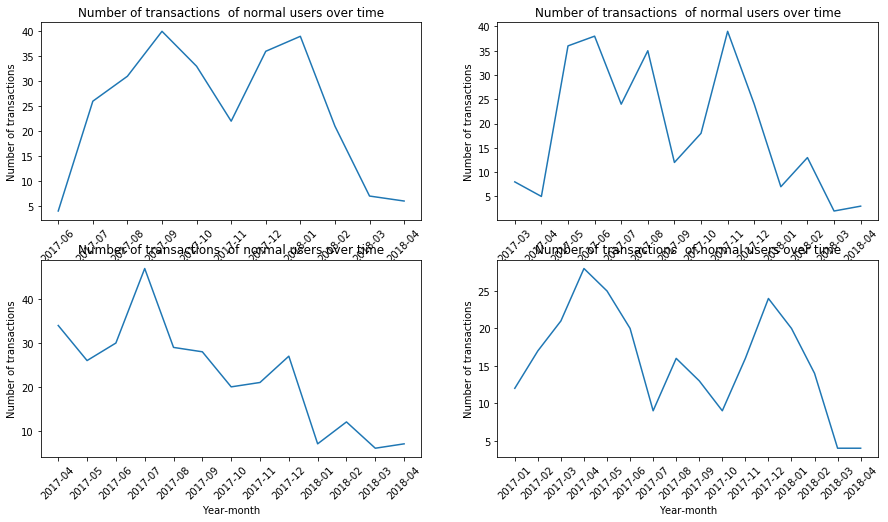

In [22]:
df_normals_temp = df_trans[df_trans['card_id'].isin(normals_ids)].groupby(['card_id','purchase_ym']).size().reset_index().rename({0:'n_trans'}, axis=1)
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_normals_temp[df_normals_temp.card_id==normals_ids[i]]['purchase_ym'], y=df_normals_temp[df_normals_temp.card_id==normals_ids[i]]['n_trans'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Number of transactions  of normal users over time')
    ax.set_xlabel('Year-month')
    ax.set_ylabel('Number of transactions')
plt.show()

It doesn't seem to be a big different neither. The number of transactions in both groups decay with time. It might be because the data is truncated only to windows of 3 months for each user and merchant... <br>
One could thought that the outlier users may have used the cards quite often at some point, but they lost insterest, while the normal users keep is normal behavior. Let's try to find some feature of this regard (for instance the ratio between the maximum and median values over time should be grater for outliers).

In [23]:
df_amounts_over_time = df_trans.groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_amounts_over_time.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_00007093c1,2017-02,1100.199951
1,C_ID_00007093c1,2017-03,866.899902
2,C_ID_00007093c1,2017-04,1203.249878
3,C_ID_00007093c1,2017-05,686.999939
4,C_ID_00007093c1,2017-06,1464.599854


In [24]:
def ratio_max_amount(amounts):
    return(pd.DataFrame({'ratio_amount': [amounts.max()/amounts.median()]}))
df_ratios = df_amounts_over_time.groupby('card_id')['purchase_amount_raw'].apply(ratio_max_amount)
df_ratios.head()

,,ratio_amount
card_id,,
C_ID_00007093c1,0,2.497954
C_ID_0001506ef0,0,1.944136
C_ID_000183fdda,0,3.906667
C_ID_00027503e2,0,1.529051
C_ID_0002c7c2c1,0,2.468608


In [25]:
df_ratios = df_ratios.reset_index(level=0)
df_log = df_log.join(df_ratios.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116,-1.0,6.788005
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147,1.0,2.729797
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14,1.0,3.782484
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57,-1.0,5.460994
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101,-1.0,2.587446


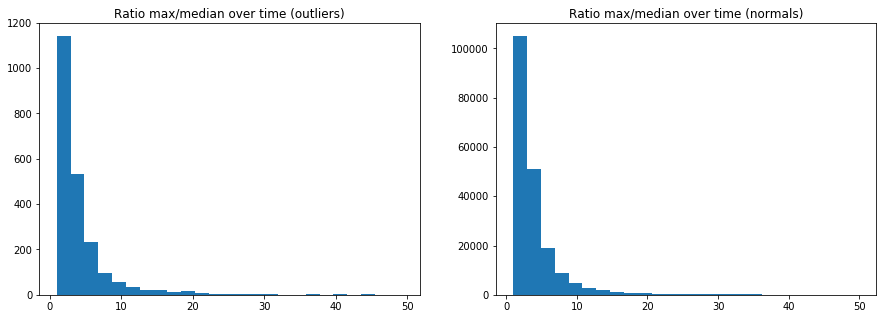

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df_log['target']<-33) & (df_log['ratio_amount']<50)]['ratio_amount'], bins=25)
plt.title('Ratio max/median over time (outliers)')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df_log['target']>-33) & (df_log['ratio_amount']<50)]['ratio_amount'], bins=25)
plt.title('Ratio max/median over time (normals)')
plt.show()

The observed difference, although it's in line with expectations, is too little to be useful.

Another way to see if a user lost interest in the product is checking the differences between the usages of the card. 

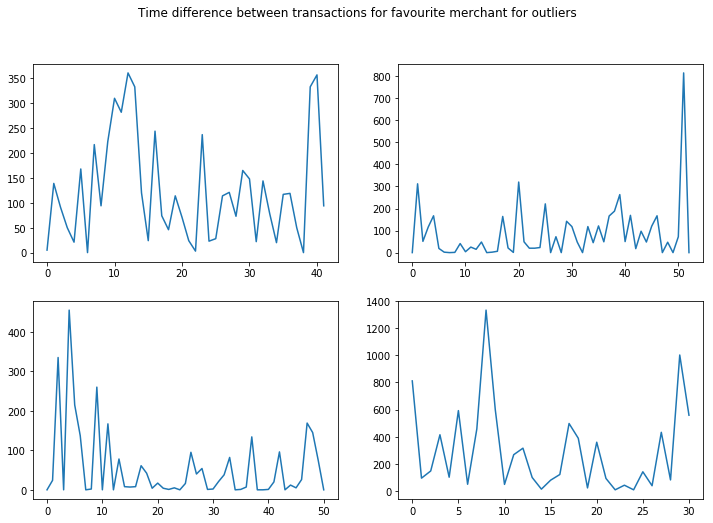

In [27]:
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    id_merch_out_temp = df_trans[df_trans['card_id']==outs_ids[i]].groupby('merchant_id').size().reset_index().rename(columns={0:'n_merch'}).sort_values('n_merch',ascending=False).head(1)['merchant_id'].values[0]
    dates_out_temp = df_trans[(df_trans['card_id']==outs_ids[i]) & (df_trans['merchant_id']==id_merch_out_temp)].sort_values('purchase_date')['purchase_date'].values
    plt.plot(np.diff(dates_out_temp)/3.6e+12)
    plt.suptitle("Time difference between transactions for favourite merchant for outliers")
plt.show()

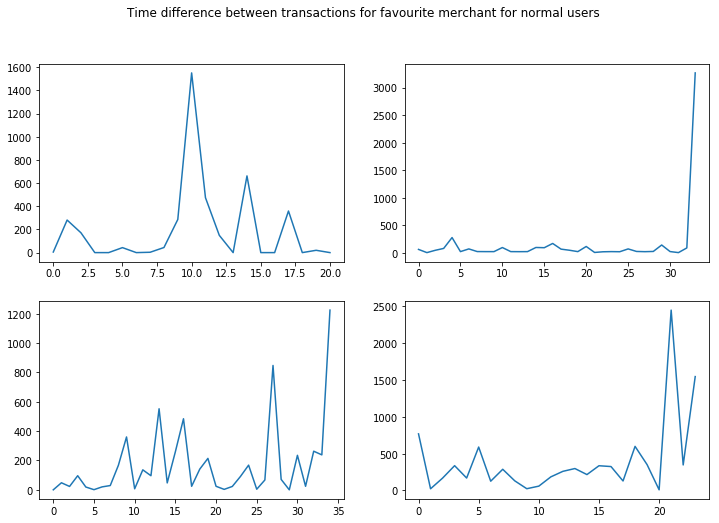

In [28]:
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    id_merch_norm_temp = df_trans[df_trans['card_id']==normals_ids[i]].groupby('merchant_id').size().reset_index().rename(columns={0:'n_merch'}).sort_values('n_merch',ascending=False).head(1)['merchant_id'].values[0]
    dates_norm_temp = df_trans[(df_trans['card_id']==normals_ids[i]) & (df_trans['merchant_id']==id_merch_norm_temp)].sort_values('purchase_date')['purchase_date'].values
    plt.plot(np.diff(dates_norm_temp)/3.6e+12)
plt.suptitle("Time difference between transactions for favourite merchant for normal users")
plt.show()

It doesn't seem to be a pattern in the differences to distinguish both groups, since the behavour that one would expect for the outliers is more similar to the one observed in the normal users. It fact, it seems that the time differences for normal users is larger than the outliers. We could also measure the standard deviation, since it may be more variability for the outliers.

In [62]:
def diff_times_fav(user):
    id_merch_temp = user.groupby('merchant_id').size().idxmax()
    dates_temp = user[user['merchant_id']==id_merch_temp].sort_values('purchase_date')['purchase_date'].values
    diff_temp = (np.diff(dates_temp)/3.6e+12).astype(float)
    return(pd.DataFrame({'diff_time_fav_mean': [diff_temp.mean()], 'diff_time_fav_std': [diff_temp.std()]}))

df_diff_times = df_trans.groupby('card_id')[['merchant_id','purchase_date']].apply(diff_times_fav)
df_diff_times = df_diff_times.reset_index(level=0)
df_diff_times.head()

,card_id,diff_time_fav_mean,diff_time_fav_std
0,C_ID_00007093c1,278.100000,303.042830
0,C_ID_0001506ef0,492.166667,318.086685
0,C_ID_000183fdda,365.818182,487.926190
0,C_ID_00027503e2,541.800000,537.363527
0,C_ID_0002c7c2c1,708.428571,667.418236


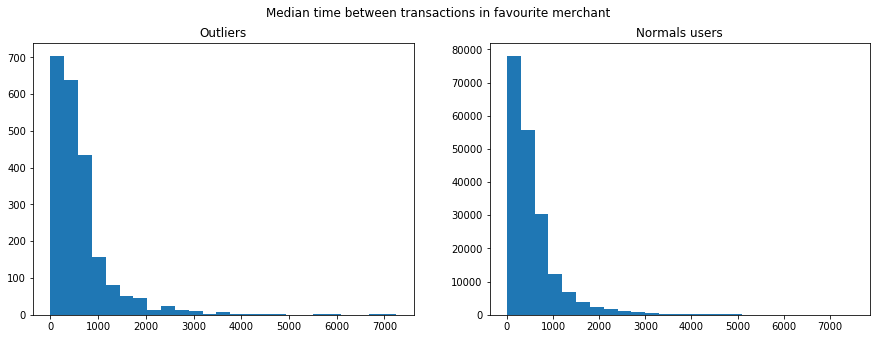

In [63]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_outs)) & (df_diff_times['diff_time_fav_mean']<7500)]['diff_time_fav_mean'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_norms)) & (df_diff_times['diff_time_fav_mean']<7500)]['diff_time_fav_mean'], bins=25)
plt.title('Normals users')
plt.suptitle('Median time between transactions in favourite merchant')
plt.show()

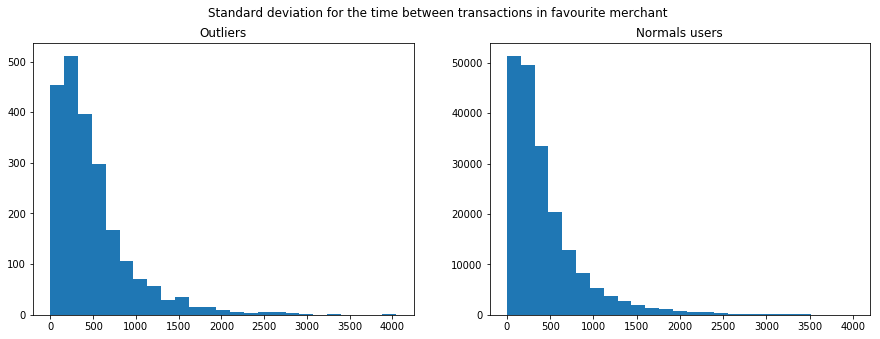

In [64]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_outs)) & (df_diff_times['diff_time_fav_std']<4100)]['diff_time_fav_std'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_norms)) & (df_diff_times['diff_time_fav_std']<4000)]['diff_time_fav_std'], bins=25)
plt.title('Normals users')
plt.suptitle('Standard deviation for the time between transactions in favourite merchant')
plt.show()

It seems that both the mean and the std of the outliers is greater than for the normal users, specially the std.

These features are not defined for some users: the ones that only have one transaction for each merchant. We will impute these values as zeros.

In [150]:
df_diff_times['diff_time_fav_mean'].fillna(0, inplace=True)
df_diff_times['diff_time_fav_std'].fillna(0, inplace=True)

In [65]:
df_log = df_log.join(df_diff_times.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount,diff_time_mean,diff_time_std,diff_time_fav_mean,diff_time_fav_std
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116,-1.0,6.788005,26.806691,36.482921,63.600000,69.857283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147,1.0,2.729797,30.758721,67.967694,373.920000,505.526333
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14,1.0,3.782484,276.073171,377.129750,313.480000,360.365827
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57,-1.0,5.460994,58.469880,82.887256,410.000000,488.171589
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101,-1.0,2.587446,24.282209,27.421614,94.259259,95.007053


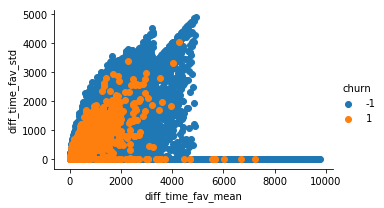

In [183]:
fg = sns.FacetGrid(data=df_log, hue='churn', aspect=1.61)
fg.map(plt.scatter, 'diff_time_fav_mean','diff_time_fav_std').add_legend()

This graph has a bit extrange shape for normal users, since it seems to have two differenciated peaks. But I have no idea what does it mean... It seems to be a straight line (maybe y=x). Besides, the users with largest times between transactions have zero standard deviation. It would probably correspond to users which only have two transactions very far in time.

We will repeat the same but with all the transactions and not only the most common merchant, since this measure might by distorted by the 3 months limit.

In [52]:
def diff_times(user):
    diff_temp = (np.diff(np.sort(user.values))/3.6e+12).astype(float)
    return(pd.DataFrame({'diff_time_mean': [diff_temp.mean()], 'diff_time_std': [diff_temp.std()]}))

df_diff_times2 = df_trans.groupby('card_id')['purchase_date'].apply(diff_times)
df_diff_times2 = df_diff_times2.reset_index(level=0)
df_diff_times2.head()

,card_id,diff_time_mean,diff_time_std
0,C_ID_00007093c1,86.982609,155.933207
0,C_ID_0001506ef0,164.000000,235.795041
0,C_ID_000183fdda,38.571429,68.245256
0,C_ID_00027503e2,246.913043,216.738856
0,C_ID_0002c7c2c1,130.063492,169.226051


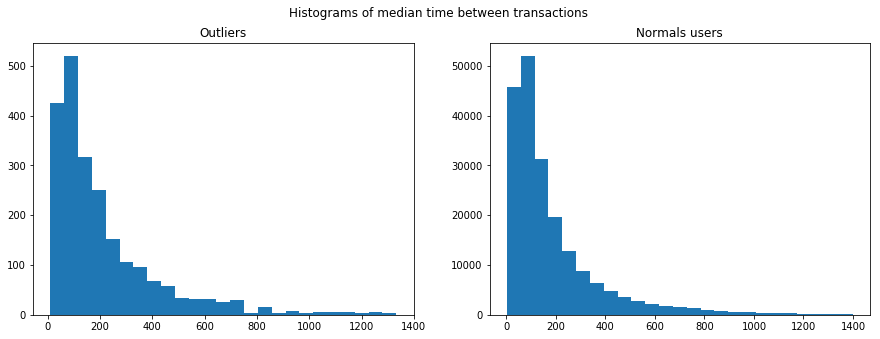

In [56]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_diff_times2[(df_diff_times2['card_id'].isin(ids_all_outs)) & (df_diff_times2['diff_time_mean']<1400)]['diff_time_mean'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times2[(df_diff_times2['card_id'].isin(ids_all_norms)) & (df_diff_times2['diff_time_mean']<1400)]['diff_time_mean'], bins=25)
plt.title('Normals users')
plt.suptitle('Histograms of median time between transactions')
plt.show()

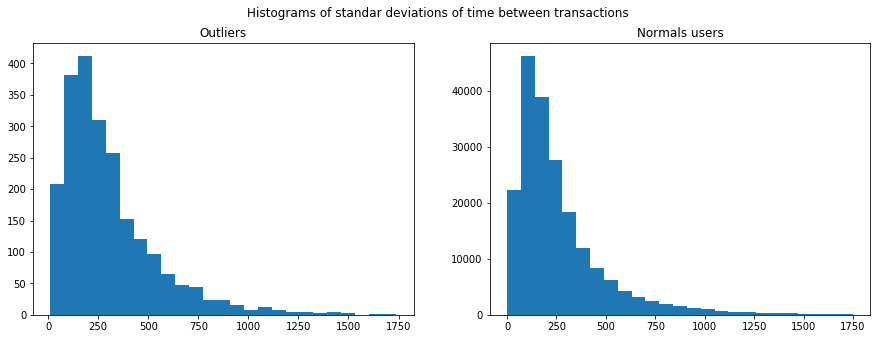

In [58]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_diff_times2[(df_diff_times2['card_id'].isin(ids_all_outs)) & (df_diff_times2['diff_time_std']<1750)]['diff_time_std'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times2[(df_diff_times2['card_id'].isin(ids_all_norms)) & (df_diff_times2['diff_time_std']<1750)]['diff_time_std'], bins=25)
plt.title('Normals users')
plt.suptitle('Histograms of standar deviations of time between transactions')
plt.show()

As with the measures for the favourite merchants, these quantities seem to be slightly larger for outliers than for normal users.

In [59]:
df_log = df_log.join(df_diff_times2.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount,diff_time_mean,diff_time_std
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116,-1.0,6.788005,26.806691,36.482921
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147,1.0,2.729797,30.758721,67.967694
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14,1.0,3.782484,276.073171,377.129750
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57,-1.0,5.460994,58.469880,82.887256
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101,-1.0,2.587446,24.282209,27.421614


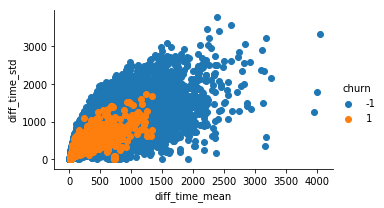

In [61]:
fg = sns.FacetGrid(data=df_log, hue='churn', aspect=1.61)
fg.map(plt.scatter, 'diff_time_mean','diff_time_std').add_legend()

The last feature that we will derive is a flag indicating wether the customer appears in the file of new transactions (new merchants added the last two months of available data).

In [87]:
df_log['in_new'] = (df_log['card_id'].isin(df_new_trans['card_id'].values))*1
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount,diff_time_mean,diff_time_std,diff_time_fav_mean,diff_time_fav_std,in_new
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,-1,20646.298828,270,116,-1.0,6.788005,26.806691,36.482921,63.600000,69.857283,1
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,-1,29577.232422,345,147,1.0,2.729797,30.758721,67.967694,373.920000,505.526333,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,-1,1890.995972,42,14,1.0,3.782484,276.073171,377.129750,313.480000,360.365827,1
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,-1,5719.293945,84,57,-1.0,5.460994,58.469880,82.887256,410.000000,488.171589,1
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,-1,22311.408203,164,101,-1.0,2.587446,24.282209,27.421614,94.259259,95.007053,1


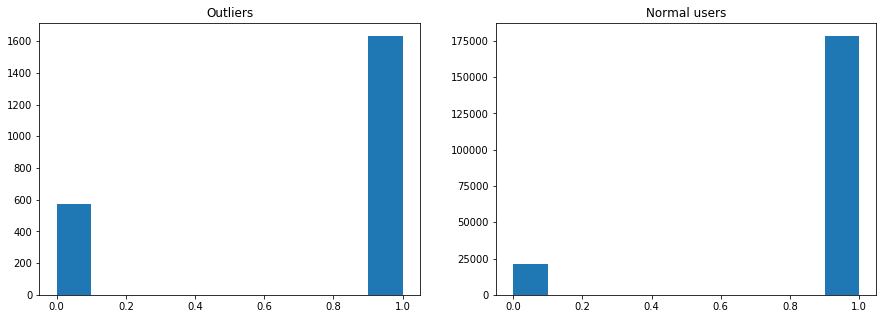

In [88]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[df_log['target']<-33]['in_new'])
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[df_log['target']>-33]['in_new'])
plt.title('Normal users')
plt.show()

For this feature the difference seems remarkable between both sets.

## Classifications models

The sample is unbalanced, since there are much more normal users that outliers (approx. 1%), so we will try [different techniques](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) to obtain a balanced one before using any binary classification techniques. The date must be splited into train and validation sets before applying these techniques, in order to avoid that some information from test data bleeds into the model training. We will use 5-folds cross-validation.

In [276]:
kf = KFold(n_splits=5)

In [569]:
X = df_log.drop(['first_active_month','card_id','target','churn'], axis=1)
y = df_log['churn']

### Over-sampling using SMOTE
This technique creates new observations instead of replicating them, by choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, observation.

First we will try with the logistic regression model. Let's check if there is some feature that is clearly non-significant for the problem.

In [277]:
os = SMOTE(random_state=1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train[columns], y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Check the importance of the variables
    logit_model = sm.Logit(os_data_y, os_data_X)
    result = logit_model.fit()
    print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.565091
         Iterations 5
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.185      
Dependent Variable:   y                AIC:              361148.0353
Date:                 2019-02-21 16:34 BIC:              361297.4796
No. Observations:     319524           Log-Likelihood:   -1.8056e+05
Df Model:             13               LL-Null:          -2.2148e+05
Df Residuals:         319510           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
feature_1           -0.1040   0.0041 -25.6684 0.0000 -0.1119 -0.0961
feature_2           -0.1498 

There are no feature with p-values greater that 0.05 in more that one fold, so we will keep all of them. Let's train the model and look at the confusion matrices.

In [519]:
os = SMOTE(random_state=1)
p_cut = 0.8

y_pred = np.zeros(y.shape[0])
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Fit the model
    logreg = LogisticRegression()
    logreg.fit(os_data_X, os_data_y)
    y_pred[test_index] = logreg.predict_proba(X_test)[:,1] 

In [518]:
#Find the cutting point for which the proportion of correctly classified outliers is greater
props = [0]*30
cuts = np.linspace(0.7,1,len(props))
for i in range(len(props)):
    matrix = metrics.confusion_matrix(y, 1*(y_pred>cuts[i]))
    props[i] = matrix[1][1]/(matrix[0][1] + matrix[1][0])

cut_opt = cuts[props.index(max(props))]
metrics.confusion_matrix(y, 1*(y_pred>cut_opt))

array([[174804,  24906],
       [  1313,    894]])

**The proportion of correctly classified outliers with respect ot the wrong classified ones using logistic regression is 0.034097.**

We tried with different values of the cut-off probability (of belonging to class 1) and the confussion matrices do not improve. That is, we are not able to correctly identify outliers with this technique since there are a lot of normal costumers with higher probabilities of being outliers, as we can see in the histograms below.

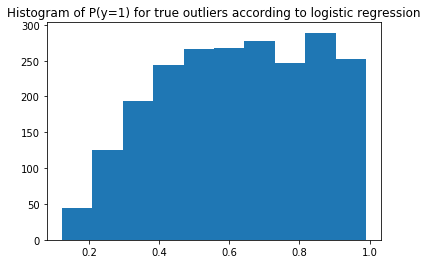

In [499]:
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to logistic regression")
plt.show()

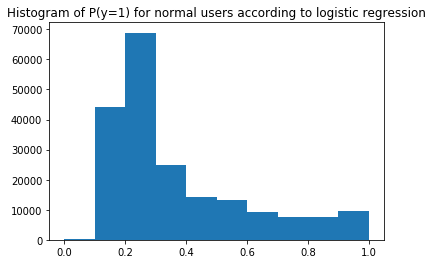

In [500]:
plt.hist(y_pred[y==0])
plt.title("Histogram of P(y=1) for normal users according to logistic regression")
plt.show()

We will try now with LGBM, which has been quite popular lately (although it is a bit sensitive to overfitting).

In [353]:
import lightgbm as lgb
cut = 0.7

y_pred = np.zeros(y.shape[0])
feature_importance_df = pd.DataFrame()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #LGBM train
    lgb_train = lgb.Dataset(os_data_X, os_data_y)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    params = {
        'task': 'train',
        'objective': 'binary', 
        'metric': 'binary_error',
        'verbose': 1
    }
    gbm = lgb.train(params, lgb_train, num_boost_round=1000, early_stopping_rounds=10,
                    valid_sets=[lgb_train,lgb_eval], valid_names=['train', 'eval'], 
                    categorical_feature=[0,1,2,6,12], verbose_eval=100)
    
    #Predictions
    y_pred[test_index] = 1*(gbm.predict(X_test, num_iteration=gbm.best_iteration)>cut)
    
    #Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = os_data_X.columns
    fold_importance_df["importance"] = gbm.feature_importance()
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
metrics.confusion_matrix(y, y_pred)
#https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data

Training until validation scores don't improve for 10 rounds.
[100]	train's binary_error: 0.0457743	eval's binary_error: 0.0568542
[200]	train's binary_error: 0.0220922	eval's binary_error: 0.0340234
[300]	train's binary_error: 0.0140834	eval's binary_error: 0.025208
[400]	train's binary_error: 0.0103592	eval's binary_error: 0.0216175
Early stopping, best iteration is:
[434]	train's binary_error: 0.00977078	eval's binary_error: 0.0209984
Training until validation scores don't improve for 10 rounds.
[100]	train's binary_error: 0.0441941	eval's binary_error: 0.057498
[200]	train's binary_error: 0.0236541	eval's binary_error: 0.0368463
[300]	train's binary_error: 0.0157485	eval's binary_error: 0.0268176
[400]	train's binary_error: 0.0114264	eval's binary_error: 0.0225337
[500]	train's binary_error: 0.00911674	eval's binary_error: 0.020726
Early stopping, best iteration is:
[575]	train's binary_error: 0.00799006	eval's binary_error: 0.0195622
Training until validation scores don't improve 

array([[198943,    767],
       [  2132,     75]])

**The proportion of correctly classified outliers with respect ot the wrong classified ones using LGBM is 0.02587.**

The confusion matrix is still quite bad, although we are able (at least) to sort the variables by importance (understood as the number of times that a feature is used in a model).

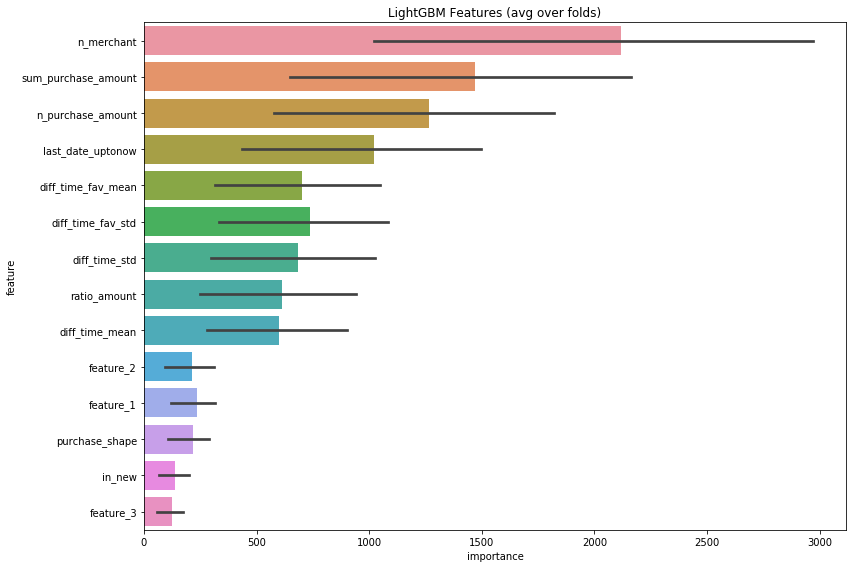

In [349]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

We see that the less relevant features are the categorical ones. <br>
*Note: only the featues diff_time_mean and diff_time_std are highly correlated, with a correlation of 0.82.*

Let's try now with SVC.

In [487]:
from sklearn.svm import SVC

y_pred = np.zeros(y.shape[0])
i=1

for train_index, test_index in kf.split(X):
    print(i)
    i+=1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Fit the SVC
    clf = SVC(kernel='poly', degree=3, max_iter=1000, random_state=1)
    clf.fit(os_data_X, os_data_y)
    y_pred[test_index] = clf.predict(X_test)

metrics.confusion_matrix(y, y_pred)

1
2
3
4
5


array([[120431,  79279],
       [  1345,    862]])

**The proportion of correctly classified outliers with respect ot the wrong classified ones using SVC is 0.01069.**

The polynomial kernel with degree 3 seems to be the best one, but the result is terrible anyway.

Let's try now a multi-layer Perceptron classifier with three layers of 20 neurons each.

In [502]:
from sklearn.neural_network import MLPClassifier

y_pred = np.zeros(y.shape[0])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Fit the MLPC
    clf = MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=100, early_stopping=True, verbose=10,  random_state=1, tol=0.001)
    clf.fit(os_data_X, os_data_y)
    y_pred[test_index] = clf.predict_proba(X_test)[:,1]

Iteration 1, loss = 2.54153750
Validation score: 0.701875
Iteration 2, loss = 1.25169948
Validation score: 0.737208
Iteration 3, loss = 0.99600151
Validation score: 0.776922
Iteration 4, loss = 1.07958775
Validation score: 0.741777
Iteration 5, loss = 0.88445708
Validation score: 0.750790
Iteration 6, loss = 0.82872523
Validation score: 0.794511
Iteration 7, loss = 0.77051435
Validation score: 0.764373
Iteration 8, loss = 0.69907446
Validation score: 0.764154
Iteration 9, loss = 0.61853361
Validation score: 0.796295
Iteration 10, loss = 0.56830499
Validation score: 0.802272
Iteration 11, loss = 0.55349100
Validation score: 0.782681
Iteration 12, loss = 0.52400046
Validation score: 0.781836
Iteration 13, loss = 0.49228693
Validation score: 0.810566
Iteration 14, loss = 0.48488494
Validation score: 0.810253
Iteration 15, loss = 0.46650511
Validation score: 0.808594
Iteration 16, loss = 0.45947314
Validation score: 0.815166
Iteration 17, loss = 0.44816835
Validation score: 0.820831
Iterat

Iteration 2, loss = 1.20138989
Validation score: 0.667731
Iteration 3, loss = 1.08231075
Validation score: 0.743623
Iteration 4, loss = 0.89470830
Validation score: 0.680030
Iteration 5, loss = 0.88694332
Validation score: 0.669076
Iteration 6, loss = 0.80154178
Validation score: 0.762432
Iteration 7, loss = 0.78202284
Validation score: 0.711326
Iteration 8, loss = 0.73553391
Validation score: 0.786029
Iteration 9, loss = 0.66598560
Validation score: 0.792602
Iteration 10, loss = 0.59834326
Validation score: 0.753920
Iteration 11, loss = 0.59115059
Validation score: 0.772478
Iteration 12, loss = 0.53369179
Validation score: 0.795575
Iteration 13, loss = 0.52746922
Validation score: 0.795637
Iteration 14, loss = 0.48846915
Validation score: 0.812568
Iteration 15, loss = 0.47887895
Validation score: 0.803211
Iteration 16, loss = 0.45877945
Validation score: 0.801521
Iteration 17, loss = 0.44897705
Validation score: 0.807874
Iteration 18, loss = 0.44339084
Validation score: 0.808969
Itera

Iteration 10, loss = 0.65239621
Validation score: 0.801302
Iteration 11, loss = 0.59025356
Validation score: 0.783841
Iteration 12, loss = 0.58258313
Validation score: 0.796452
Iteration 13, loss = 0.51646096
Validation score: 0.779367
Iteration 14, loss = 0.50541087
Validation score: 0.784874
Iteration 15, loss = 0.49126936
Validation score: 0.709525
Iteration 16, loss = 0.48468705
Validation score: 0.809218
Iteration 17, loss = 0.45673458
Validation score: 0.819325
Iteration 18, loss = 0.45088432
Validation score: 0.804400
Iteration 19, loss = 0.46007781
Validation score: 0.790788
Iteration 20, loss = 0.44363006
Validation score: 0.709306
Iteration 21, loss = 0.44447453
Validation score: 0.819513
Iteration 22, loss = 0.43197998
Validation score: 0.815445
Iteration 23, loss = 0.44119923
Validation score: 0.781119
Iteration 24, loss = 0.44990215
Validation score: 0.816478
Iteration 25, loss = 0.42557051
Validation score: 0.823424
Iteration 26, loss = 0.41978859
Validation score: 0.8173

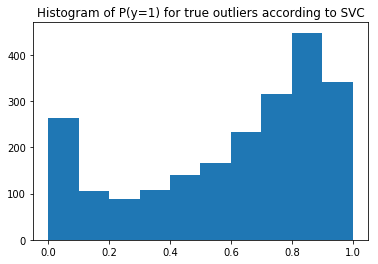

In [503]:
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to SVC")
plt.show()

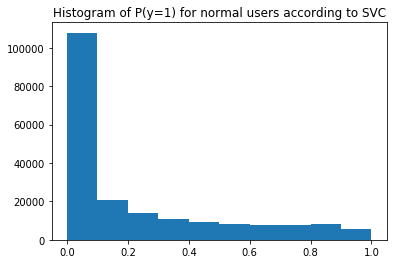

In [505]:
plt.hist(y_pred[y==0])
plt.title("Histogram of P(y=1) for normal users according to SVC")
plt.show()

In [516]:
props = [0]*30
cuts = np.linspace(0.7,1,len(props))
for i in range(len(props)):
    matrix = metrics.confusion_matrix(y, 1*(y_pred>cuts[i]))
    props[i] = matrix[1][1]/(matrix[0][1] + matrix[1][0])

cut_opt = cuts[props.index(max(props))]
metrics.confusion_matrix(y, 1*(y_pred>cut_opt))

array([[186999,  12711],
       [  1465,    742]])

**The proportion of correctly classified outliers with respect ot the wrong classified ones using MLPClassifier with 20 neurons is 0.05234.**

Let's try to add more neurons to the layers to see if it improves.

In [520]:
from sklearn.neural_network import MLPClassifier

y_pred = np.zeros(y.shape[0])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Fit the MLPC
    clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=100, early_stopping=True, verbose=10,  random_state=1, tol=0.001)
    clf.fit(os_data_X, os_data_y)
    y_pred[test_index] = clf.predict_proba(X_test)[:,1]

Iteration 1, loss = 3.15492019
Validation score: 0.720621
Iteration 2, loss = 1.55657708
Validation score: 0.684631
Iteration 3, loss = 1.29939436
Validation score: 0.748318
Iteration 4, loss = 1.01473804
Validation score: 0.728288
Iteration 5, loss = 0.82023910
Validation score: 0.727600
Iteration 6, loss = 0.55481782
Validation score: 0.819109
Iteration 7, loss = 0.49544061
Validation score: 0.810753
Iteration 8, loss = 0.44812808
Validation score: 0.826902
Iteration 9, loss = 0.44883404
Validation score: 0.819767
Iteration 10, loss = 0.42804855
Validation score: 0.803962
Iteration 11, loss = 0.42900438
Validation score: 0.838732
Iteration 12, loss = 0.41509029
Validation score: 0.826370
Iteration 13, loss = 0.40547015
Validation score: 0.838325
Iteration 14, loss = 0.40165406
Validation score: 0.843927
Iteration 15, loss = 0.39453298
Validation score: 0.831941
Iteration 16, loss = 0.39093713
Validation score: 0.840297
Iteration 17, loss = 0.38929458
Validation score: 0.844083
Iterat

Iteration 12, loss = 0.43565259
Validation score: 0.815072
Iteration 13, loss = 0.43038907
Validation score: 0.823240
Iteration 14, loss = 0.42251964
Validation score: 0.815698
Iteration 15, loss = 0.42014487
Validation score: 0.828216
Iteration 16, loss = 0.41317315
Validation score: 0.832254
Iteration 17, loss = 0.40534855
Validation score: 0.832285
Iteration 18, loss = 0.40696045
Validation score: 0.831659
Iteration 19, loss = 0.39439863
Validation score: 0.840203
Iteration 20, loss = 0.39361139
Validation score: 0.842894
Iteration 21, loss = 0.38871194
Validation score: 0.824492
Iteration 22, loss = 0.38330086
Validation score: 0.844522
Iteration 23, loss = 0.37814798
Validation score: 0.817325
Iteration 24, loss = 0.37517135
Validation score: 0.842519
Iteration 25, loss = 0.36901853
Validation score: 0.835164
Iteration 26, loss = 0.36461605
Validation score: 0.841799
Iteration 27, loss = 0.36474933
Validation score: 0.848778
Iteration 28, loss = 0.36355646
Validation score: 0.8459

Iteration 6, loss = 0.58778533
Validation score: 0.764284
Iteration 7, loss = 0.52184738
Validation score: 0.754365
Iteration 8, loss = 0.45317100
Validation score: 0.817104
Iteration 9, loss = 0.44541602
Validation score: 0.721447
Iteration 10, loss = 0.43409253
Validation score: 0.828118
Iteration 11, loss = 0.42836681
Validation score: 0.822924
Iteration 12, loss = 0.42776726
Validation score: 0.825990
Iteration 13, loss = 0.44356554
Validation score: 0.827179
Iteration 14, loss = 0.41042460
Validation score: 0.832749
Iteration 15, loss = 0.40609414
Validation score: 0.822611
Iteration 16, loss = 0.40195920
Validation score: 0.782402
Iteration 17, loss = 0.39573832
Validation score: 0.844358
Iteration 18, loss = 0.38681644
Validation score: 0.830434
Iteration 19, loss = 0.38137107
Validation score: 0.850272
Iteration 20, loss = 0.37604838
Validation score: 0.852744
Iteration 21, loss = 0.37347001
Validation score: 0.826084
Iteration 22, loss = 0.36920941
Validation score: 0.784749
I

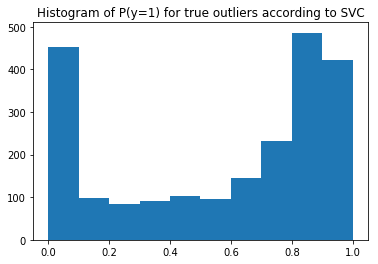

In [521]:
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to SVC")
plt.show()

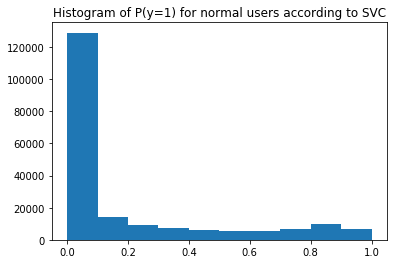

In [522]:
plt.hist(y_pred[y==0])
plt.title("Histogram of P(y=1) for normal users according to SVC")
plt.show()

In [523]:
props = [0]*30
cuts = np.linspace(0.7,1,len(props))
for i in range(len(props)):
    matrix = metrics.confusion_matrix(y, 1*(y_pred>cuts[i]))
    props[i] = matrix[1][1]/(matrix[0][1] + matrix[1][0])

cut_opt = cuts[props.index(max(props))]
metrics.confusion_matrix(y, 1*(y_pred>cut_opt))

array([[189212,  10498],
       [  1563,    644]])

**The proportion of correctly classified outliers with respect ot the wrong classified ones using MLPClassifier with 50 neurons is 0.05339.**

Although the proportion has improved a little bit with respect to the 20 neurons layers, we see at the histograms that the bar of zero probability for true outliers has increased. <br>
Just in case, let's try with a neural network with just one layer.

In [534]:
from sklearn.neural_network import MLPClassifier

y_pred = np.zeros(y.shape[0])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Over-sample the data
    os_data_X, os_data_y = os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
    os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
    #Fit the MLPC
    clf = MLPClassifier(hidden_layer_sizes=(50), max_iter=100, early_stopping=True, verbose=10,  random_state=1, tol=0.001)
    clf.fit(os_data_X, os_data_y)
    y_pred[test_index] = clf.predict_proba(X_test)[:,1]

Iteration 1, loss = 2.47282583
Validation score: 0.760367
Iteration 2, loss = 1.55973599
Validation score: 0.740869
Iteration 3, loss = 1.42504879
Validation score: 0.695334
Iteration 4, loss = 1.43133352
Validation score: 0.660032
Iteration 5, loss = 1.29789174
Validation score: 0.660783
Iteration 6, loss = 1.41027738
Validation score: 0.749038
Iteration 7, loss = 1.40448759
Validation score: 0.761212
Iteration 8, loss = 1.34224511
Validation score: 0.786530
Iteration 9, loss = 1.39591836
Validation score: 0.628799
Iteration 10, loss = 1.24187689
Validation score: 0.772666
Iteration 11, loss = 1.33194961
Validation score: 0.733484
Iteration 12, loss = 1.21457604
Validation score: 0.785654
Iteration 13, loss = 1.19996669
Validation score: 0.658749
Iteration 14, loss = 1.14344878
Validation score: 0.786405
Iteration 15, loss = 1.07419546
Validation score: 0.784997
Iteration 16, loss = 1.15014935
Validation score: 0.727600
Iteration 17, loss = 1.14044742
Validation score: 0.586768
Iterat

Iteration 18, loss = 1.21513983
Validation score: 0.792947
Iteration 19, loss = 1.22206863
Validation score: 0.780180
Iteration 20, loss = 1.16515582
Validation score: 0.653983
Iteration 21, loss = 1.18245740
Validation score: 0.756837
Iteration 22, loss = 0.96691481
Validation score: 0.613868
Iteration 23, loss = 1.18883437
Validation score: 0.687559
Iteration 24, loss = 1.16665994
Validation score: 0.729332
Validation score did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.


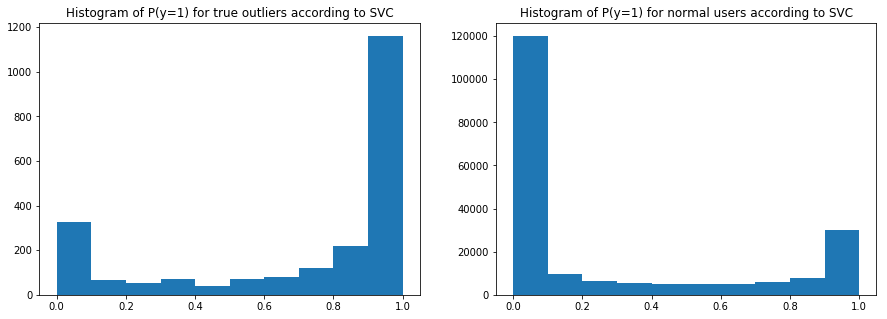

In [535]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to SVC")
plt.subplot(1, 2, 2)
plt.hist(y_pred[y==0])
plt.title("Histogram of P(y=1) for normal users according to SVC")
plt.show()

In [538]:
y_csv = 1*(y_pred>=0.9) #Dummy variable for Zoltan's stratification model

In [531]:
props = [0]*30
cuts = np.linspace(0.7,1,len(props))
for i in range(len(props)):
    matrix = metrics.confusion_matrix(y, 1*(y_pred>cuts[i]))
    props[i] = matrix[1][1]/(matrix[0][1] + matrix[1][0])

cut_opt = cuts[props.index(max(props))]
matrix = metrics.confusion_matrix(y, 1*(y_pred>cut_opt))
print(matrix)
print("Prop. of correctly classified outliers with respect to the wrong classified ones using MLPClassifier with one layer: {:.5f}".format(matrix[1][1]/(matrix[0][1] + matrix[1][0])))

[[175763  23947]
 [  1235    972]]
Prop. of correctly classified outliers with respect ot the wrong classified ones using MLPClassifier with one layer: 0.03860


Although the proportion got worse, the shape of the histograms is interesting. The two small bars at the ends may suggest that there are two different groups of users whose labels are the oppossite that would be expected. Maybe we should try to perform some clustering on the customers to try to find these two groups and then apply two different models for them.

### Randomly undersampling

In [463]:
# Probar a cambiar los 0s por -1s
from sklearn.svm import SVC

y_pred = np.zeros(y.shape[0])

i = 0
for train_index, test_index in kf.split(X):
    print(i)
    i+=1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Under-sample the data
    ix_out = np.where(y_train!=0)[0]
    ix_norm = np.setdiff1d(train_index, ix_out, assume_unique=True)
    ix_norm_sub = np.random.choice(ix_norm, len(ix_out), replace=False)
    ix_sub = np.sort(np.concatenate((ix_out, ix_norm_sub)))
    X_train = X.iloc[ix_sub]
    y_train = y.iloc[ix_sub]
    
    #Fit the SVC
    clf = SVC(gamma='auto', probability=True, max_iter=5000, random_state=1)
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict_proba(X_test)[:,1]

0
1
2
3
4


In [472]:
metrics.confusion_matrix(y, 1*(y_pred>=0.8))

array([[198386,   1324],
       [  2207,      0]])

It is not working at all, let's take a look at the probabilities of the true outliers.

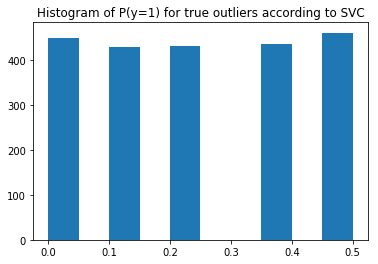

In [477]:
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to SVC")
plt.show()

Let's try the neural network with just one layer to see if the undersampling is worth it or not.

In [545]:
from sklearn.neural_network import MLPClassifier

y_pred = np.zeros(y.shape[0])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Under-sample the data
    ix_out = np.where(y_train!=0)[0]
    ix_norm = np.setdiff1d(train_index, ix_out, assume_unique=True)
    ix_norm_sub = np.random.choice(ix_norm, len(ix_out), replace=False)
    ix_sub = np.sort(np.concatenate((ix_out, ix_norm_sub)))
    X_train = X.iloc[ix_sub]
    y_train = y.iloc[ix_sub]
    
    #Fit the MLPC
    clf = MLPClassifier(hidden_layer_sizes=(50), max_iter=100, early_stopping=True, random_state=1, tol=0.001)
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict_proba(X_test)[:,1]

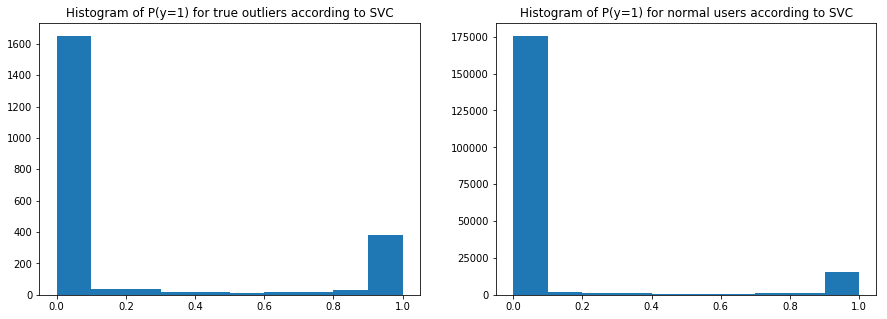

In [546]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_pred[y!=0])
plt.title("Histogram of P(y=1) for true outliers according to SVC")
plt.subplot(1, 2, 2)
plt.hist(y_pred[y==0])
plt.title("Histogram of P(y=1) for normal users according to SVC")
plt.show()

Ok, this approach clearly doesn't work...

### Target distribution for the group of "probable" outliers

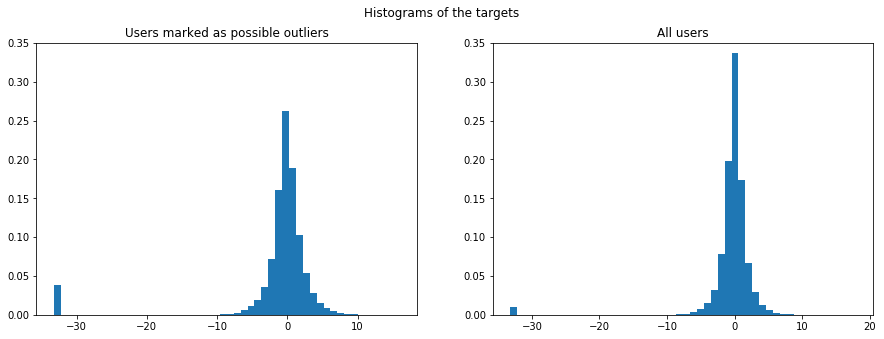

In [661]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df_log.loc[(y_csv==1),'target'], bins=50, density=True)
plt.ylim((0,0.35))
plt.title("Users marked as possible outliers")
plt.subplot(1,2,2)
plt.hist(df_log['target'], bins=50, density=True)
plt.ylim((0,0.35))
plt.title("All users")
plt.suptitle("Histograms of the targets")
plt.show()

As expected, the proportion of outliers among the marked ones is bigger than in the whole set. Besides, we are getting rid of a big part of the users with target exactly zero (the high central bar for the whole set). But we can not see any other pattern in the target of the possible outliers.

# Predictions for test set
First we need to derive the same set of features for the test set.

In [4]:
df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)


In [593]:
df_trans_test = pd.concat([df_hist_trans, df_new_trans])
df_trans_test = df_trans_test[df_trans_test['card_id'].isin(df_test['card_id'].unique())].reset_index()

In [595]:
df_trans_test['purchase_amount_raw'] = df_trans_test['purchase_amount']/0.00150265118 + 497.06
df_trans_test = df_trans_test[df_trans_test['authorized_flag']=='Y'] #We will only use authorized transactions

In [596]:
#Number of transactions and merchants, and total amount
df_amount_trans_test = df_trans_test.groupby('card_id')['purchase_amount_raw'].sum().reset_index().rename(columns={'purchase_amount_raw': 'sum_purchase_amount'})
df_n_trans_test = df_trans_test.groupby('card_id')['purchase_amount_raw'].count().reset_index().rename(columns={'purchase_amount_raw': 'n_purchase_amount'})
df_n_merch_test = df_trans_test.groupby('card_id')['merchant_id'].nunique().reset_index().rename(columns={'merchant_id': 'n_merchant'})

In [609]:
df_log_test = df_test.join(df_amount_trans_test.set_index('card_id'), on='card_id', how='inner') 
df_log_test = df_log_test.join(df_n_trans_test.join(df_n_merch_test.set_index('card_id'), on='card_id').set_index('card_id'), on='card_id')

In [611]:
#Time up to May 1th, 2018
df_trans_test['purchase_date'] = pd.to_datetime(df_trans_test['purchase_date'])
df_agg_time_test = df_trans_test.groupby('card_id').agg({'purchase_date': ['max']}).reset_index(drop=False)
df_agg_time_test.columns = ['card_id','purchase_date_max']
df_agg_time_test['last_date_uptonow'] = (datetime.datetime.strptime('May 1 2018', '%b %d %Y') - df_agg_time_test['purchase_date_max']).dt.days

In [612]:
df_agg_time_test.drop('purchase_date_max', axis=1, inplace=True)
df_log_test = df_log_test.merge(df_agg_time_test, on='card_id', how='left')

In [614]:
#Create year-month variable
df_trans_test = create_date_year_month(df_trans_test, 'purchase_date', 'purchase')

In [615]:
#Shape of the transactions over time
df_coeffs_test = df_trans_test.groupby('card_id')[['purchase_ym','purchase_amount_raw']].apply(compute_shape)
df_coeffs_test = df_coeffs_test.reset_index(level=0)

In [616]:
df_log_test = df_log_test.join(df_coeffs_test.set_index('card_id'), on='card_id') 

In [618]:
#Ratio max/median amount
df_amounts_over_time_test = df_trans_test.groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_ratios_test = df_amounts_over_time_test.groupby('card_id')['purchase_amount_raw'].apply(ratio_max_amount)
df_ratios_test = df_ratios_test.reset_index(level=0)

In [619]:
df_log_test = df_log_test.join(df_ratios_test.set_index('card_id'), on='card_id') 

In [621]:
#Time differences for favourite merchant
df_diff_times_test = df_trans_test.groupby('card_id')[['merchant_id','purchase_date']].apply(diff_times_fav)
df_diff_times_test = df_diff_times_test.reset_index(level=0)
df_diff_times_test['diff_time_fav_mean'].fillna(0, inplace=True)
df_diff_times_test['diff_time_fav_std'].fillna(0, inplace=True)

In [622]:
df_log_test = df_log_test.join(df_diff_times_test.set_index('card_id'), on='card_id') 

In [624]:
#Time differences for all transactions
df_diff_times2_test = df_trans_test.groupby('card_id')['purchase_date'].apply(diff_times)
df_diff_times2_test = df_diff_times2_test.reset_index(level=0)

In [625]:
df_log_test = df_log_test.join(df_diff_times2_test.set_index('card_id'), on='card_id') 

In [627]:
#If the user is in the new transactions set
df_log_test['in_new'] = (df_log_test['card_id'].isin(df_new_trans['card_id'].values))*1

In [628]:
df_log_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,sum_purchase_amount,n_purchase_amount,n_merchant,last_date_uptonow,purchase_shape,ratio_amount,diff_time_fav_mean,diff_time_fav_std,diff_time_mean,diff_time_std,in_new
0,2017-04,C_ID_0ab67a22ab,3,3,1,3519.644287,47,26,61,1.0,2.745825,674.333333,469.472281,171.760870,220.189364,1
1,2017-01,C_ID_130fd0cbdd,2,3,0,6578.439941,86,36,10,-1.0,3.117373,206.285714,111.557435,129.976471,661.486916,1
2,2017-08,C_ID_b709037bc5,5,1,1,4991.930176,11,9,48,-1.0,1.653987,1031.000000,384.000000,479.300000,452.097346,1
3,2017-12,C_ID_d27d835a9f,2,1,0,4960.286621,36,33,13,1.0,3.937740,876.000000,322.000000,91.685714,170.451631,1
4,2015-12,C_ID_2b5e3df5c2,5,1,1,81343.054688,93,51,18,-1.0,5.142969,741.333333,1209.291161,120.239130,207.286840,1


Now we train the perceptron with the whole train set and predict the class for the test set.

In [629]:
from sklearn.neural_network import MLPClassifier

#Over-sample the data
os_data_X, os_data_y = os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X, columns=X.columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=['y'])
    
#Fit the MLPC
clf = MLPClassifier(hidden_layer_sizes=(50), max_iter=100, early_stopping=True, verbose=10,  random_state=1, tol=0.001)
clf.fit(os_data_X, os_data_y)

#Predictions for the test set
X_test = df_log_test.drop(['first_active_month','card_id'], axis=1)
y_test_prob = clf.predict_proba(X_test)[:,1]

Iteration 1, loss = 2.46642555
Validation score: 0.579390
Iteration 2, loss = 1.60676156
Validation score: 0.735266
Iteration 3, loss = 1.54783925
Validation score: 0.771969
Iteration 4, loss = 1.36877657
Validation score: 0.751314
Iteration 5, loss = 1.36966547
Validation score: 0.614341
Iteration 6, loss = 1.29146010
Validation score: 0.722498
Iteration 7, loss = 1.24201324
Validation score: 0.775825
Iteration 8, loss = 1.27677272
Validation score: 0.699539
Iteration 9, loss = 1.19962833
Validation score: 0.607982
Iteration 10, loss = 1.22712275
Validation score: 0.772796
Iteration 11, loss = 1.10643146
Validation score: 0.753468
Iteration 12, loss = 1.12811503
Validation score: 0.764058
Iteration 13, loss = 1.19354986
Validation score: 0.561614
Iteration 14, loss = 1.11114504
Validation score: 0.811977
Iteration 15, loss = 1.10708411
Validation score: 0.599044
Iteration 16, loss = 1.05407335
Validation score: 0.757874
Iteration 17, loss = 1.03433114
Validation score: 0.770467
Iterat

In [639]:
y_test_pred = 1*(y_test_prob >= 0.9)
print("Percentage of users marked as possible outliers: {:.2f}%".format(y_test_pred.sum()/X_test.shape[0]*100))

Percentage of users marked as possible outliers: 0.27%


This is extrange taking into account the numbers obtained with the train set and the number of total outliers:

In [643]:
print("Percentage of possible outliers for the train set (5-folds cv): {:.2f}%".format(y_csv.sum()/X.shape[0]*100))
print("Percentage of true outliers in the train set: {:.2f}%".format(y.sum()/X.shape[0]*100))

Percentage of possible outliers for the train set (5-folds cv): 15.37%
Percentage of true outliers in the train set: 1.09%


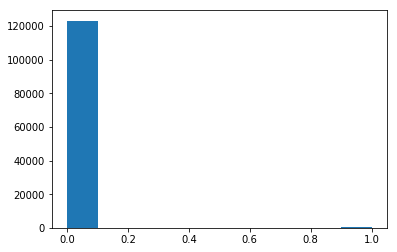

In [644]:
plt.hist(y_test_prob)
plt.show()

The probabilities obtained for the test set are also extrange, since the model is completelly sure of which users are outliers and which ones are not... Maybe the train and test sets do not have the same distribution.

# Save the results

In [543]:
#Dummy variable of "possible outliers" just for the train set
sub_df = pd.DataFrame({
    "card_id": df_log["card_id"].values
})

sub_df["possible_out"] = y_csv
sub_df.to_csv("output/possible_outliers.csv", index=False)

In [645]:
#Possible outliers for the test set
sub_df = pd.DataFrame({
    "card_id": df_log_test["card_id"].values
})

sub_df["possible_out"] = y_test_pred
sub_df.to_csv("output/possible_outliers_test.csv", index=False)

# Estimate the number of outliers in the test set
Knowing the sample size of the test set and the LB score for the submission with all zeros, we can approximate the number of outliers in the test set. Just to know if the result we obtained (332 outliers) makes sense or not. <br>
If $n_T$ is the size of the test set, and $n_O, n_N$ are the number of outliers and normal users, respectively ($n_T=n_O+n_N$), then,
$$e=\left(\frac{1}{n_T}\sum_{i=1}^{n_T} (y_i-\hat{y}_i)^2\right)^{1/2} = \left(\frac{1}{n_T}\sum_{i=1}^{n_T} y_i^2\right)^{1/2}.$$
Then, in order to get an upper bound on the number of outliers, we can assume that $y_i=0$ for all the normal users, and then,
$$e^2 \simeq \frac{n_O}{n_T}(-33.22)^2 \rightarrow n_O \simeq \frac{e^2 n_T}{33.22^2}.$$

In [6]:
n_T = df_test.shape[0]
e = 3.952

#First I will get an upper bound
n_O_upper = int(np.round((e**2)*n_T/(33.22**2)))
print("Upper bound for the number of test outliers: {}".format(n_O_upper))

Upper bound for the number of test outliers: 1750


In order to get a more precise estimation, we will randomly sample target values from the train set to use them as $y_i$. This approach would only work if the target distributions on the test set is the same as in the train set.

In [53]:
targets = df[df['target']>(-33)]['target'].values.tolist()

m = 200 #Number of repetitions of the experiment
n_Os = [0]*m

#Repeat the computation for different sub-samples of the targets
for iter in range(m):
    random.seed(iter)
    y_sample = random.sample(targets, n_T)
    e_temp_new = 0
    
    #Find the number of outliers corresponding with a RMSE e
    for i in range(1440,1,-1): #For the first replications we saw the the number is always around 1420
        e_temp_old = e_temp_new
        targets_i = np.asarray([-33.2]*i + y_sample[i:])
        e_temp_new = np.sqrt(np.mean(targets_i**2))
        
        #Stop when the obtained error is close to the real one
        if (e_temp_new<e): break

    n_Os[iter] = i if (np.abs(e_temp_old-e) > np.abs(e_temp_new-e)) else (i+1)

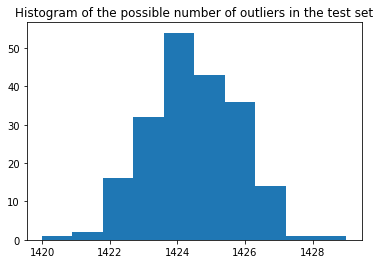

In [60]:
plt.hist(n_Os)
plt.title("Histogram of the possible number of outliers in the test set")
plt.show()

In [61]:
#We estimate the number of outliers as the mean of the obtained values
n_O = int(np.round(np.mean(n_Os)))
print("Mean value of possible number of outliers in the test set: {}".format(n_O))
print("Possible percentage of outliers in the test set: {:.2f}%".format(n_O/n_T*100))

Mean value of possible number of outliers in the test set: 1424
Possible percentage of outliers in the test set: 1.15%


So we see that the estimated proportion of outliers in the test set is 1.15%, which is similar to the 1% of outliers in the train set. However, it is quite far from the 0.2% predicted by the model. <br>
Then it could be that the customers merked by the model are a subset of these outliers, or that the model is completely wrong and it is not able to detect outliers at all (if the distributions of test and train are very different).